# Mini-Assignment 4: Link Analysis

**IMPORTANT: This is not the final version! The assignments will be changed.**

In this mini-assignment, we will exploit graph algorithms to improve search results. For our dataset of scientific papers, we look at two graphs in particular: the co-authorship network and the citation network.

The citation network is similar to the link network of the web: Citations are like web links pointing to other documents. We can therefore apply the same network-based ranking methods.

## Code from previous exercises

In [1]:
import pickle, bz2
from collections import defaultdict, namedtuple, Counter
from math import log10, sqrt
from IPython.display import display, HTML
import matplotlib.pyplot as plt

# show plots inline within the notebook
%matplotlib inline
# set plots' resolution
plt.rcParams['savefig.dpi'] = 100

In [2]:
Ids_file = 'data/malaria__Ids.pkl.bz2'
Summaries_file = 'data/malaria__Summaries.pkl.bz2'
Citations_file = 'data/malaria__Citations.pkl.bz2'
Abstracts_file = 'data/malaria__Abstracts.pkl.bz2'

Ids = pickle.load( bz2.BZ2File( Ids_file, 'rb' ) )
Summaries = pickle.load( bz2.BZ2File( Summaries_file, 'rb' ) )
Citations = pickle.load( bz2.BZ2File( Citations_file, 'rb' ) )

paper = namedtuple( 'paper', ['title', 'authors', 'year', 'doi'] )

for (id, paper_info) in Summaries.items():
    Summaries[id] = paper( *paper_info )

In [3]:
def display_summary( id, show_abstract=False, show_id=True, extra_text='' ):
    """
    Function for printing a paper's summary through IPython's Rich Display System.
    Trims long author lists, and adds a link to the paper's DOI (when available).
    """
    s = Summaries[id]
    lines = []
    title = s.title
    if s.doi != '':
        title = '<a href=http://dx.doi.org/%s>%s</a>' % (s.doi, title)
    title = '<strong>' + title + '</strong>'
    lines.append(title)
    authors = ', '.join( s.authors[:20] ) + ('' if len(s.authors) <= 20 else ', ...')
    lines.append(str(s.year) + '. ' + authors)
    if (show_abstract):
        lines.append('<small><strong>Abstract:</strong> <em>%s</em></small>' % Abstracts[id])
    if (show_id):
        lines.append('[ID: %d]' % id)
    if (extra_text != ''):
         lines.append(extra_text)
    display( HTML('<br>'.join(lines)) )

In [4]:
def tokenize(text):
    return text.split(' ')

def preprocess(tokens):
    result = []
    for token in tokens:
        result.append(token.lower())
    return result

In [5]:
Abstracts = pickle.load( bz2.BZ2File( Abstracts_file, 'rb' ) )

inverted_index = defaultdict(set)

for (id, abstract) in Abstracts.items():
    for term in preprocess(tokenize(abstract)):
        inverted_index[term].add(id)

tf_matrix = defaultdict(Counter)
length_values = defaultdict(int)

for (doc_id, abstract) in Abstracts.items():
    tokens = preprocess(tokenize(abstract))
    tf_matrix[doc_id] = Counter(tokens)
    l = 0
    for t in tf_matrix[doc_id].keys():
        l += tf_matrix[doc_id][t] ** 2
    length_values[doc_id] = sqrt(l)

def tf(t,d):
    return float(tf_matrix[d][t])

def df(t):
    return float(len(inverted_index[t]))
    
def num_documents():
    return float(len(Abstracts))

def length_tf(d):
    return length_values[d]

# We don't need to keep this object in memory any longer:
Abstracts = {}

## Co-authorship network

`Summaries` maps paper *ids* to paper *summaries*. Let us now create here mappings by different criteria.

We'll start by building a mapping from *authors* to the set of *ids* of papers they authored. 
We'll be using Python's [sets](http://docs.python.org/3/library/stdtypes.html#set-types-set-frozenset) again for that purpose.

In [6]:
papers_of_author = defaultdict(set)

for id,p in Summaries.items():
    for a in p.authors:
        papers_of_author[a].add( id )

In [7]:
papers_of_author['Clauset A']

{24130474, 26456841}

In [8]:
for id in papers_of_author['Clauset A']:
    display_summary(id)

We now build a co-authorship network, a graph linking *authors*, to the set of *co-authors* they have published with.

In [9]:
coauthors = defaultdict(set)

for p in Summaries.values():
    for a in p.authors:
        coauthors[a].update( p.authors )

# The code above results in each author being listed as having co-autored with himself/herself.
# We remove these self-references here:
for a,ca in coauthors.items():
    ca.remove(a)

In [10]:
print(', '.join( coauthors['Clauset A'] ))

Larremore DB, Sharp PM, Liu W, Proto WR, Loy DE, Hahn BH, Rayner JC, Buckee CO, Speede S, Sundararaman SA, Plenderleith LJ


Now we can have a look at some basic statistics about our graph:

In [11]:
print('Number of nodes: %8d (node = author)' % len(coauthors))
print('Number of links: %8d (link = collaboration between the two linked authors on at least one paper)'  \
        % sum( len(cas) for cas in coauthors.values() ))

Number of nodes:   114572 (node = author)
Number of links:  2488486 (link = collaboration between the two linked authors on at least one paper)


With this data in hand, we can plot the [degree distribution](https://en.wikipedia.org/wiki/Degree_distribution) by showing the number of collaborators a scientist has published with:

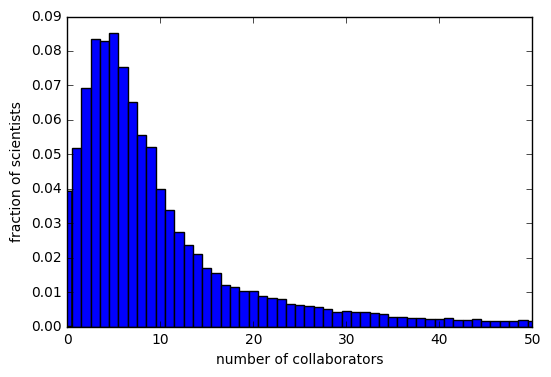

In [12]:
plt.hist( x=[ len(ca) for ca in coauthors.values() ], bins=range(55), histtype='bar', align='left', normed=True )
plt.xlabel('number of collaborators')
plt.ylabel('fraction of scientists')
plt.xlim(0,50);

## Citations network

We'll start by expanding the `Citations` dataset into two mappings: 

* `papers_citing[id]`: papers citing a given paper;
* `cited_by[id]`: papers cited by a given paper (in other words, its list of references).

If we see the Citations dataset as a directed graph where papers are nodes, and citations links between then, then `papers_citing` gives you the list of a node's incoming links, whereas `cited_by` gives you the list of its outgoing links.

The dataset was assembled by querying for papers citing a given paper. As a result, the data mapped to in `cited_by` (its values) is necessarily limited to ids of papers that are part of the dataset.

In [13]:
papers_citing = Citations  # no changes needed, this is what we are storing already in the Citations dataset

cited_by = defaultdict(list)

for ref, papers_citing_ref in papers_citing.items():
    for id in papers_citing_ref:
        cited_by[ id ].append( ref )

Let us now look at an arbitrary paper, let's say PubMed ID 16820458 ("Changes in the spoilage-related microbiota of beef during refrigerated storage under different packaging conditions"). We can now use the `cited_by` mapping to retrieve what we know of its list of references.

As mentioned above, because the process generating the dataset asked for papers citing a given paper (and not papers a paper cites), the papers we get through `cited_by` are then necessarily all members of our datasets, and we can therefore find them in `Summaries`.

In [14]:
paper_id = 24130474
refs = { id : Summaries[id].title for id in cited_by[paper_id] }
print(len(refs), 'references identified for the paper with id', paper_id)
refs

26 references identified for the paper with id 24130474


{7606788: 'The large diverse gene family var encodes proteins involved in cytoadherence and antigenic variation of Plasmodium falciparum-infected erythrocytes.',
 9500614: 'Parasite antigens on the infected red cell surface are targets for naturally acquired immunity to malaria.',
 9916084: 'Antibody recognition of Plasmodium falciparum erythrocyte surface antigens in Kenya: evidence for rare and prevalent variants.',
 10086393: 'Immunity to non-cerebral severe malaria is acquired after one or two infections.',
 10714439: 'Antibodies to variable Plasmodium falciparum-infected erythrocyte surface antigens are associated with protection from novel malaria infections.',
 11069183: 'Frequent ectopic recombination of virulence factor genes in telomeric chromosome clusters of P. falciparum.',
 11071284: 'Classification of adhesive domains in the Plasmodium falciparum erythrocyte membrane protein 1 family.',
 11349035: 'Antibodies to variant antigens on the surfaces of infected erythrocytes a

If we lookup the same paper in `papers_citing`, we now see that some of the cited papers are themselves in our dataset, but others are not (denote here by `'??'`):

In [15]:
{ id : Summaries.get(id,['??'])[0]  for id in papers_citing[paper_id] }

{25122340: '??',
 25303095: '??',
 25368109: 'Immune characterization of Plasmodium falciparum parasites with a shared genetic signature in a region of decreasing transmission.',
 25521112: '??',
 26456841: 'Ape parasite origins of human malaria virulence genes.',
 27306566: '??'}

Paper 25122340, for example, is not in our dataset and we do not have any direct information about it, but its repeated occurrence in other papers' citation lists does allow us to reconstruct a good portion of its references. Below is the list of papers in our dataset cited by that paper:

In [16]:
paper_id2 = 25122340
refs2 = { id : Summaries[id].title for id in cited_by[paper_id2] }
print(len(refs2), 'references identified for the paper with id', paper_id2)
refs2

2 references identified for the paper with id 25122340


{20862303: 'Plasmodium falciparum erythrocyte membrane protein 1 diversity in seven genomes--divide and conquer.',
 24130474: 'A network approach to analyzing highly recombinant malaria parasite genes.'}

Now that we have a better understanding about the data we're dealing with, let us obtain again some basic statistics about our graph.

In [17]:
print('Number of core ids %d (100.00 %%)' % len(Ids))

with_cit = [ id for id in Ids if papers_citing[id]!=[] ]
print('Number of papers cited at least once: %d (%.2f %%)' % (len(with_cit), 100.*len(with_cit)/len(Ids)))

isolated = set( id for id in Ids if papers_citing[id]==[] and id not in cited_by )
print('Number of isolated nodes: %d (%.2f %%)\n\t'   \
      '(papers that are not cited by any others, nor do themselves cite any in the dataset)'% (
    len(isolated), 100.*len(isolated)/len(Ids) ))

noCit_withRefs = [ id for id in Ids if papers_citing[id]==[] and id in cited_by ]
print('Number of dataset ids with no citations, but known references: %d (%.2f %%)' % (
    len(noCit_withRefs), 100.*len(noCit_withRefs)/len(Ids)))

print('(percentages calculated with respect to just the core ids (members of `Ids`) -- exclude outsider ids)\n')

Number of core ids 67028 (100.00 %)
Number of papers cited at least once: 45340 (67.64 %)
Number of isolated nodes: 18765 (28.00 %)
	(papers that are not cited by any others, nor do themselves cite any in the dataset)
Number of dataset ids with no citations, but known references: 2923 (4.36 %)
(percentages calculated with respect to just the core ids (members of `Ids`) -- exclude outsider ids)



In [18]:
Ids_set    = set( Ids )
citing_Ids = set( cited_by.keys() ) # == set( c for citing in papers_citing.itervalues() for c in citing )

outsiders = citing_Ids - Ids_set    # set difference: removes from `citing_Ids` all the ids that occur in `Ids_set`
nodes     = citing_Ids | Ids_set - isolated     # set union, followed by set difference

print('Number of (non-isolated) nodes in the graph: %d\n\t(papers with at least 1 known citation, or 1 known reference)' % len(nodes))
print(len( citing_Ids ), 'distinct ids are citing papers in our dataset.')
print('Of those, %d (%.2f %%) are ids from outside the dataset.\n' % ( len(outsiders), 100.*len(outsiders)/len(citing_Ids) ))

Number of (non-isolated) nodes in the graph: 128104
	(papers with at least 1 known citation, or 1 known reference)
98423 distinct ids are citing papers in our dataset.
Of those, 79841 (81.12 %) are ids from outside the dataset.



In [19]:
all_cits      = [ c for citing in papers_citing.values() for c in citing ]
outsider_cits = [ c for citing in papers_citing.values() for c in citing if c in outsiders ]

print('Number of links (citations) in the graph:', len(all_cits))
print('A total of %d citations are logged in the dataset.' % len(all_cits))
print('Citations by ids from outside the dataset comprise %d (%.2f %%) of that total.\n' % (
    len(outsider_cits),
    100.*len(outsider_cits)/len(all_cits) ))

Number of links (citations) in the graph: 552219
A total of 552219 citations are logged in the dataset.
Citations by ids from outside the dataset comprise 172094 (31.16 %) of that total.



#### Most cited papers

Let us now find which 10 papers are the most cited in our dataset.

In [21]:
nr_cits_per_paper = [ (id, len(cits)) for (id,cits) in papers_citing.items() ]

for (id, cits) in sorted( nr_cits_per_paper, key=lambda i:i[1], reverse=True )[:10]:
    display_summary( id, extra_text=', nr. citations: %d' % cits )

## Link Analysis for Search Engines

In order to use the citation network, we need to be able to perform some complex graph algorithms on it. To make our lives easier, we will load the data into the python package [NetworkX](https://pypi.python.org/pypi/networkx), a package for the creation, manipulation, and study of the structure, dynamics, and function of complex networks, which provides a number of these graph algorithms (such as HITS and PageRank) out of the box.

You probably have to [install the NetworkX package](https://pypi.python.org/pypi/networkx) first.

In [22]:
import networkx as nx

G = nx.DiGraph(cited_by)

We now have a NetworkX Directed Graph stored in `G`, where a node represents a paper, and an edge represents a citation. This means we can now apply the [algorithms](http://networkx.github.io/documentation/networkx-1.10/reference/algorithms.html) and [functions](http://networkx.github.io/documentation/networkx-1.10/reference/functions.html) of NetworkX to our graph:

In [23]:
print(nx.info(G))
print(nx.is_directed(G))
print(nx.density(G))

Name: 
Type: DiGraph
Number of nodes: 128104
Number of edges: 552219
Average in degree:   4.3107
Average out degree:   4.3107
True
3.365033205197717e-05


As this graph was generated from citations only, we need to add all isolated nodes (nodes that are not cited and do not cite other papers) as well:

In [24]:
G.add_nodes_from(isolated)

In [25]:
print(nx.info(G))
print(nx.is_directed(G))
print(nx.density(G))

Name: 
Type: DiGraph
Number of nodes: 146869
Number of edges: 552219
Average in degree:   3.7599
Average out degree:   3.7599
True
2.560082886552999e-05


----------

## Assignments

**Your name:** ...

### Task 1

Plot the in-degree distribution (the distribution of the number of incoming links) for the citation network. What can you tell about the shape of this distribution, and what does this tell us about the network?

In [ ]:
# Add your code here

[Write your answer text here]

### Task 2

Using the [Link Analysis](https://networkx.github.io/documentation/networkx-1.10/reference/algorithms.link_analysis.html) algorithms provided by NetworkX, calculate the PageRank score for each node in the citation network, and store them in a variable. Print out the PageRank values for the two example papers given below.

  Hint: the `pagerank_scipy` implementation tend to be considerably faster than its regular `pagerank` counterpart (but you have to install the [SciPy package](http://scipy.org/) for that).

In [ ]:
# Add your code here

# print PageRank for paper 7168798
# print PageRank for paper 21056779

### Task 3

Copy your search engine from mini-assignment 3, and create a version that incorporates a paper's PageRank score in it's final score, in addition to tf-idf. Show the result of an example query, and explain your decision on how to combine the two scores (PageRank and tf-idf).

In [ ]:
# Add your code here

[Write your answer text here]